# Resume Screening Project

In [51]:
# Import Required Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import warnings
import nltk
import string

from nltk.tokenize import TweetTokenizer
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from scipy.sparse import hstack
from nltk.corpus import stopwords
from nltk import FreqDist
from wordcloud import WordCloud
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Filter warnings
warnings.filterwarnings('ignore')

## Load Dataset

In [2]:
# Load Dataset
resumeScreeningData = pd.read_csv('ResumeScreeningDataSet.csv', encoding='utf-8')

In [3]:
# Head of Data
resumeScreeningData.head(10)

,Category,Resume
0,Data Science,Skills * Programming Languages: Python (pandas...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...
2,Data Science,"Areas of Interest Deep Learning, Control Syste..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab..."
5,Data Science,"SKILLS C Basics, IOT, Python, MATLAB, Data Sci..."
6,Data Science,Skills â¢ Python â¢ Tableau â¢ Data Visuali...
7,Data Science,Education Details \r\n B.Tech Rayat and Bahr...
8,Data Science,Personal Skills â¢ Ability to quickly grasp t...
9,Data Science,Expertise â Data and Quantitative Analysis â...


## Data Exploration

In [4]:
# Size of the Dataset
print("Size of Resume Screening Dataset: ", resumeScreeningData.shape)

Size of Resume Screening Dataset:  (962, 2)


In [5]:
# Missing values
print("Missing values for Resume Screnning Dataset:\n", resumeScreeningData.isnull().sum())

Missing values for Resume Screnning Dataset:
 Category    0
Resume      0
dtype: int64


In [6]:
# Category unique value
print ("The distinct categories of resumes in Resume Screening Dataset:")
print (resumeScreeningData['Category'].unique())

The distinct categories of resumes in Resume Screening Dataset:
['Data Science' 'HR' 'Advocate' 'Arts' 'Web Designing'
 'Mechanical Engineer' 'Sales' 'Health and fitness' 'Civil Engineer'
 'Java Developer' 'Business Analyst' 'SAP Developer' 'Automation Testing'
 'Electrical Engineering' 'Operations Manager' 'Python Developer'
 'DevOps Engineer' 'Network Security Engineer' 'PMO' 'Database' 'Hadoop'
 'ETL Developer' 'DotNet Developer' 'Blockchain' 'Testing']


In [7]:
# Count Different values in Dataset
print("\nThere are ", len(resumeScreeningData['Category'].value_counts())," diffrents values in the Resume Screening Dataset" )


There are  25  diffrents values in the Resume Screening Dataset


In [8]:
print ("The distinct categories of resumes and the number of records of each category:")
print (resumeScreeningData['Category'].value_counts())

The distinct categories of resumes and the number of records of each category:
Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
HR                           44
Hadoop                       42
Blockchain                   40
ETL Developer                40
Operations Manager           40
Data Science                 40
Sales                        40
Mechanical Engineer          40
Arts                         36
Database                     33
Electrical Engineering       30
Health and fitness           30
PMO                          30
Business Analyst             28
DotNet Developer             28
Automation Testing           26
Network Security Engineer    25
SAP Developer                24
Civil Engineer               24
Advocate                     20
Name: Category, dtype: int64


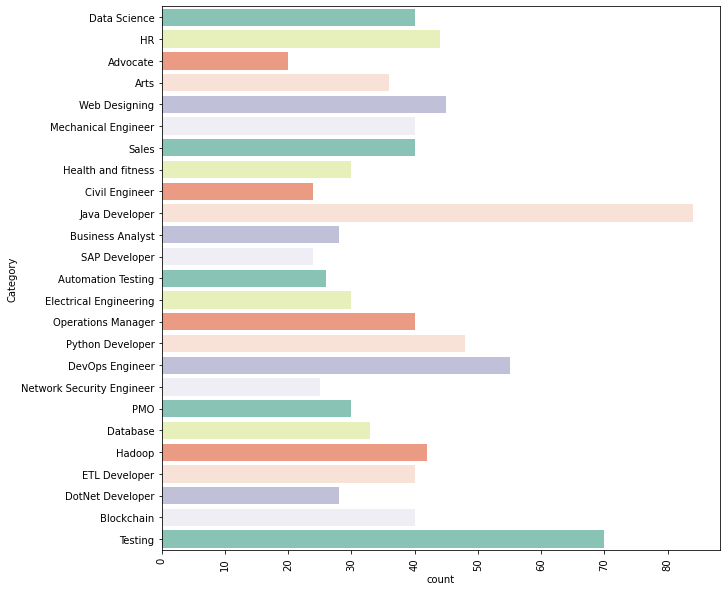

In [9]:
# Exploratory Data Analysis
plt.figure(figsize = (10,10))
plt.xticks(rotation = 90)
sns.countplot(y = "Category", data = resumeScreeningData, palette= ["#7fcdbb", "#edf8b1", "#fc9272", "#fee0d2", "#bcbddc", "#efedf5"])

plt.savefig('jobcategory_details.png')

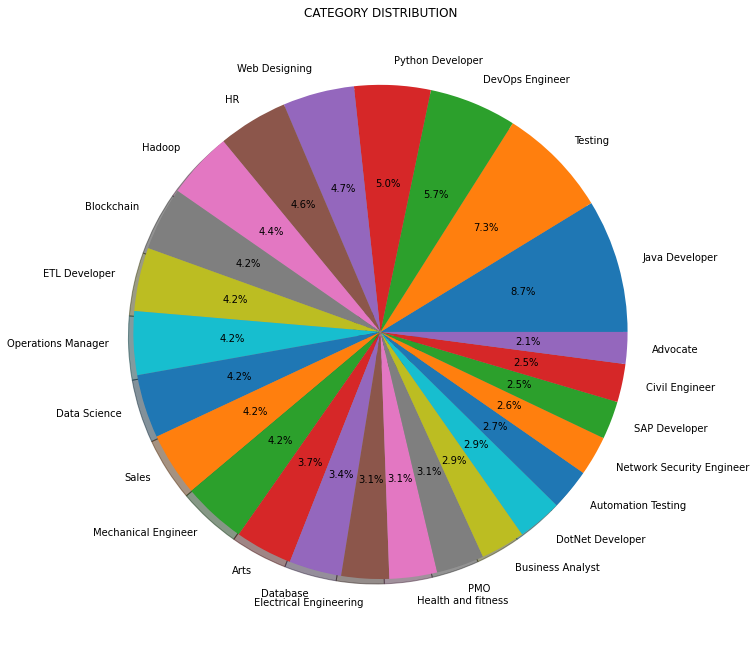

In [10]:
# Pie-chart
targetCounts = resumeScreeningData['Category'].value_counts().reset_index()['Category']
targetLabels  = resumeScreeningData['Category'].value_counts().reset_index()['index']

# Make square figures and axes
plt.figure(1, figsize = (25,25))
the_grid = GridSpec(2, 2)
plt.subplot(the_grid[0, 1], aspect = 1, title = 'CATEGORY DISTRIBUTION')
source_pie = plt.pie(targetCounts, labels = targetLabels, autopct = '%1.1f%%', shadow = True, )

## Data Cleaning

In [11]:
stopwords_english = ["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", 
                     "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", 
                     "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", 
                     "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", 
                     "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", 
                     "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", 
                     "with", "about", "against", "between", "into", "through", "during", "before", "after", 
                     "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", 
                     "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", 
                     "any", "both", "each", "few", "more", "most", "other", "some", "such", "no", "nor", "not", 
                     "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "don", 
                     "should", "now"]

def cleanResume(resumeText):
    resumeText = re.sub('http\S+\s*', ' ', resumeText)  # remove URLs
    resumeText = re.sub('RT|cc', ' ', resumeText)  # remove RT and cc
    resumeText = re.sub('#\S+', '', resumeText)  # remove hashtags
    resumeText = re.sub('@\S+', '  ', resumeText)  # remove mentions
    resumeText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', resumeText)  # remove punctuations
    resumeText = re.sub(r'[^\x00-\x7f]',r' ', resumeText) 
    resumeText = re.sub('\s+', ' ', resumeText)  # remove extra whitespace
    tokenizer = TweetTokenizer()
    resumeText = tokenizer.tokenize(resumeText)
    resumeTextLower = [word.lower() for word in resumeText]
    resumeTextClean = [word for word in resumeTextLower if (word not in stopwords_english and len(word)>2)]
    return resumeTextClean

In [12]:
resumeScreeningData['cleaned_resume'] = resumeScreeningData.Resume.apply(lambda x: cleanResume(x))

resumeScreeningData.head(10)

,Category,Resume,cleaned_resume
0,Data Science,Skills * Programming Languages: Python (pandas...,"[skills, programming, languages, python, panda..."
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,"[education, details, may, 2013, may, 2017, uit..."
2,Data Science,"Areas of Interest Deep Learning, Control Syste...","[areas, interest, deep, learning, control, sys..."
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,"[skills, python, sap, hana, tableau, sap, hana..."
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...","[education, details, mca, ymcaust, faridabad, ..."
5,Data Science,"SKILLS C Basics, IOT, Python, MATLAB, Data Sci...","[skills, basics, iot, python, matlab, data, sc..."
6,Data Science,Skills â¢ Python â¢ Tableau â¢ Data Visuali...,"[skills, python, tableau, data, visualization,..."
7,Data Science,Education Details \r\n B.Tech Rayat and Bahr...,"[education, details, tech, rayat, bahra, insti..."
8,Data Science,Personal Skills â¢ Ability to quickly grasp t...,"[personal, skills, ability, quickly, grasp, te..."
9,Data Science,Expertise â Data and Quantitative Analysis â...,"[expertise, data, quantitative, analysis, deci..."


## Data Visualization

[('exprience', 3829), ('company', 3578), ('project', 3498), ('months', 3288), ('description', 3122), ('details', 3096), ('data', 2156), ('management', 1999), ('team', 1950), ('maharashtra', 1449), ('system', 1425), ('testing', 1349), ('year', 1336), ('database', 1280), ('development', 1203), ('business', 1196), ('ltd', 1177), ('test', 1174), ('less', 1145), ('using', 1124), ('sql', 1121), ('skill', 1117), ('january', 1090), ('client', 1085), ('java', 1076), ('developer', 1069), ('engineering', 1055), ('application', 1046), ('pune', 1026), ('work', 987), ('services', 956), ('skills', 950), ('software', 887), ('pvt', 879), ('education', 857), ('responsibilities', 856), ('sales', 825), ('reports', 814), ('process', 813), ('operations', 791), ('requirements', 790), ('server', 779), ('customer', 775), ('technical', 767), ('technologies', 764), ('india', 762), ('university', 762), ('monthscompany', 746), ('design', 745), ('working', 745)]


Text(0.5, 1.0, 'Wordcloud All Types Resume')

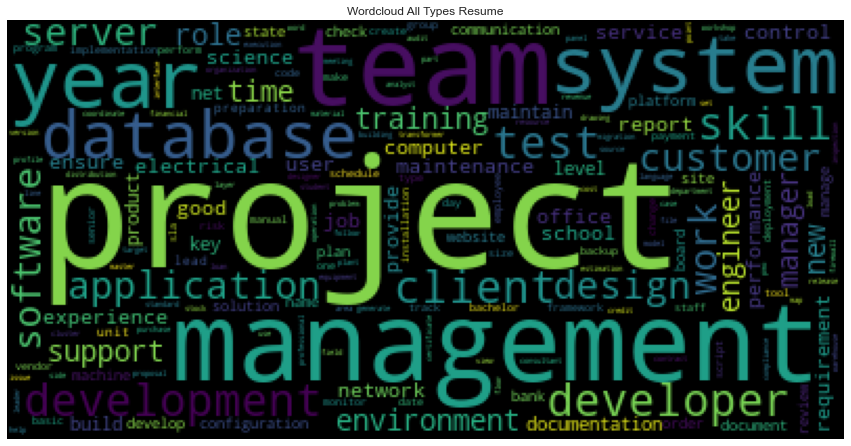

In [40]:
# Word Cloud
cleanResumeList = list(resumeScreeningData['cleaned_resume'])
cleanResume = [item for sublist in cleanResumeList for item in sublist]
recCleanResume = FreqDist(cleanResume)
mostcommon_CleanResume = recCleanResume.most_common(50)
print(mostcommon_CleanResume)

wordcloud = WordCloud().generate(",".join(str(v) for v in recCleanResume))  
plt.figure(figsize=(15,15))
plt.imshow(wordcloud)
plt.axis("off")
plt.title('Wordcloud All Types Resume')

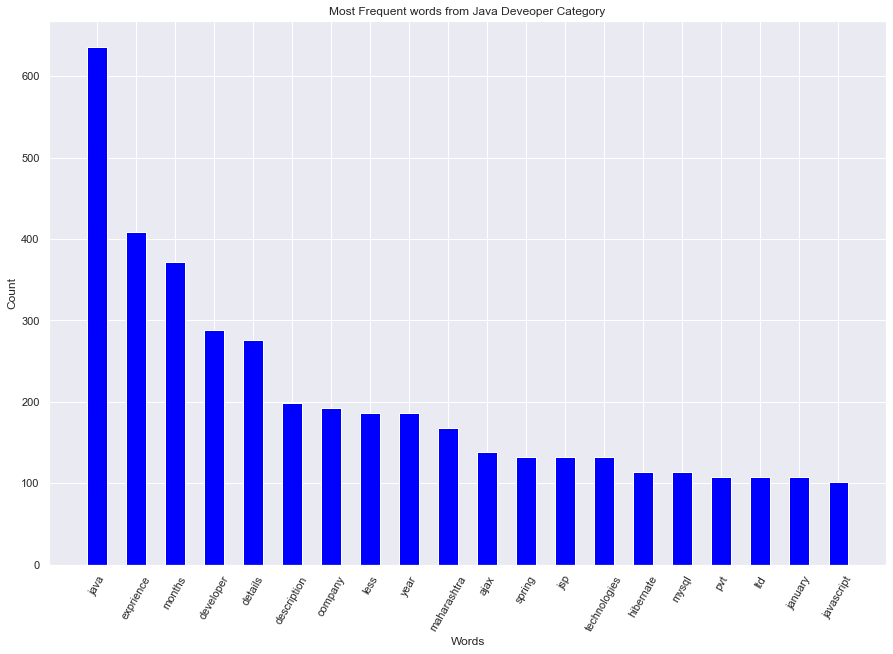

Text(0.5, 1.0, 'Wordcloud Java Developer Resume')

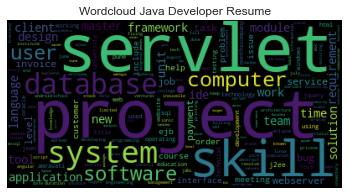

In [41]:
# Java Developer words frequency
javaDeveloperList = list(resumeScreeningData[resumeScreeningData['Category'] == 'Java Developer']['cleaned_resume'])
javaDeveloper = [item for sublist in javaDeveloperList for item in sublist]
recJavaDeveloper = FreqDist(javaDeveloper)

sns.set()
ax = plt.figure(figsize = (15, 10))

keys = []
values = []
count = 0
for word in recJavaDeveloper:
    keys.append(word)
    values.append(recJavaDeveloper.pop(word))
    count += 1
    if(count == 20):
        break

plt.bar(keys, values, color ='blue', width = 0.5)
 
plt.xlabel("Words")
plt.ylabel("Count")
plt.title("Most Frequent words from Java Deveoper Category")
plt.xticks(rotation = 60)
plt.show()

        
jd_wordcloud = WordCloud().generate(",".join(str(v) for v in recJavaDeveloper))  

plt.imshow(jd_wordcloud)
plt.axis("off")
plt.title('Wordcloud Java Developer Resume')

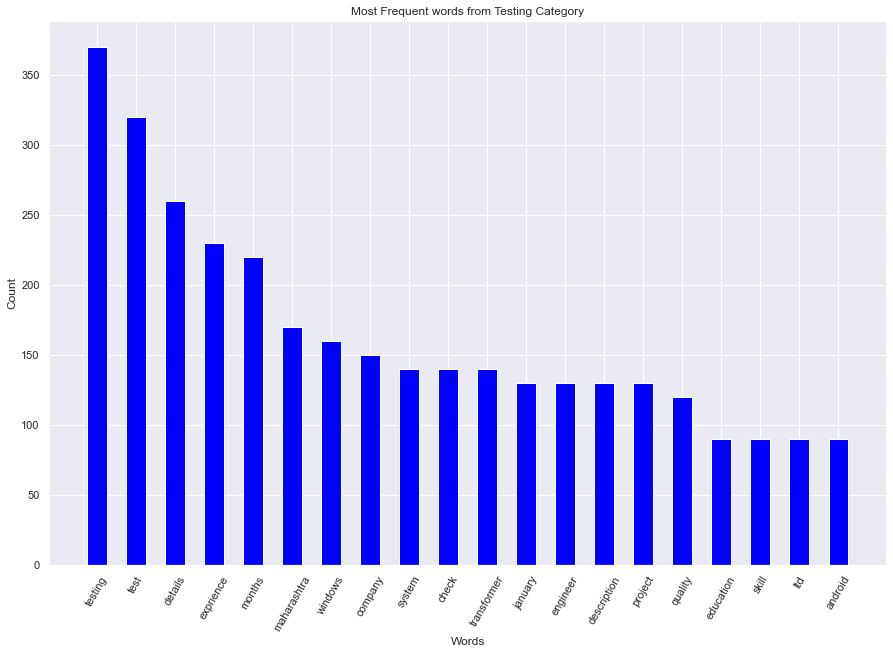

Text(0.5, 1.0, 'Wordcloud Tetsing Resume')

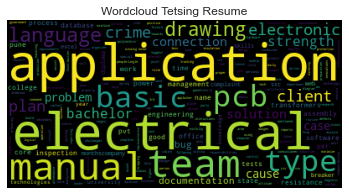

In [42]:
# Testing words frequency
testingList = list(resumeScreeningData[resumeScreeningData['Category'] == 'Testing']['cleaned_resume'])
testing = [item for sublist in testingList for item in sublist]
recTesting = FreqDist(testing)

sns.set()
ax = plt.figure(figsize = (15,10))

keys = []
values = []
count = 0
for word in recTesting:
    keys.append(word)
    values.append(recTesting.pop(word))
    count += 1
    if(count == 20):
        break

plt.bar(keys, values, color ='blue', width = 0.5)
 
plt.xlabel("Words")
plt.ylabel("Count")
plt.title("Most Frequent words from Testing Category")
plt.xticks(rotation = 60)
plt.show()

t_wordcloud = WordCloud().generate(",".join(str(v) for v in recTesting))  

plt.imshow(t_wordcloud)
plt.axis("off")
plt.title('Wordcloud Tetsing Resume')

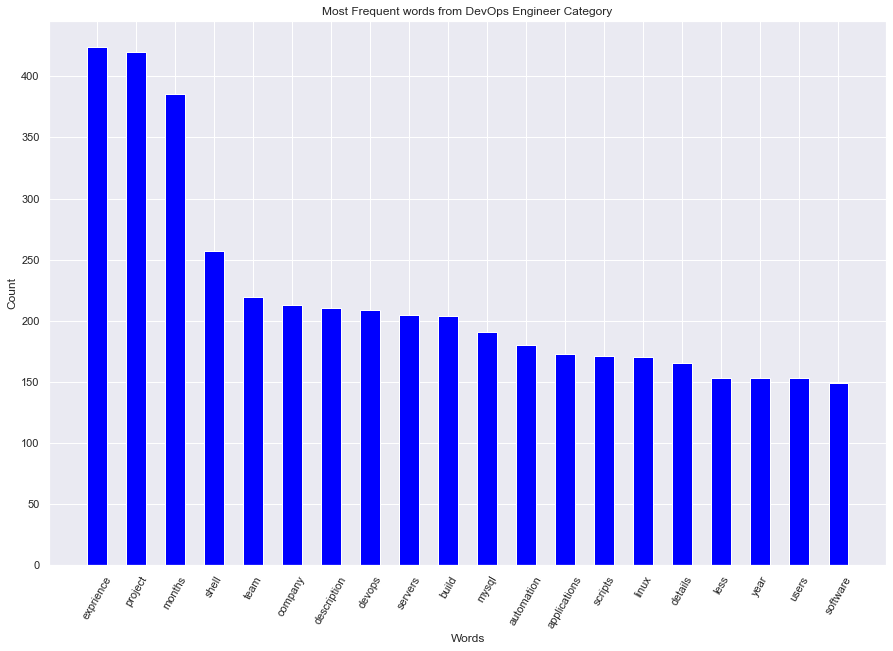

Text(0.5, 1.0, 'Wordcloud DevOps Engineer Resume')

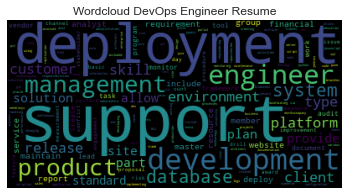

In [43]:
# DevOps Engineer  words frequency
devOpsList = list(resumeScreeningData[resumeScreeningData['Category'] == 'DevOps Engineer']['cleaned_resume'])
devOps = [item for sublist in devOpsList for item in sublist]
recDevOps = FreqDist(devOps)

sns.set()
ax = plt.figure(figsize = (15,10))

keys = []
values = []
count = 0
for word in recDevOps:
    keys.append(word)
    values.append(recDevOps.pop(word))
    count += 1
    if(count == 20):
        break

plt.bar(keys, values, color ='blue', width = 0.5)
 
plt.xlabel("Words")
plt.ylabel("Count")
plt.title("Most Frequent words from DevOps Engineer Category")
plt.xticks(rotation = 60)
plt.show()

do_wordcloud = WordCloud().generate(",".join(str(v) for v in recDevOps))  

plt.imshow(do_wordcloud)
plt.axis("off")
plt.title('Wordcloud DevOps Engineer Resume')

## Machine Learning

In [44]:
# Word vectorizer 
resumeScreeningDataML = resumeScreeningData
resumeScreeningDataML['cleaned_resume']

0      [skills, programming, languages, python, panda...
1      [education, details, may, 2013, may, 2017, uit...
2      [areas, interest, deep, learning, control, sys...
3      [skills, python, sap, hana, tableau, sap, hana...
4      [education, details, mca, ymcaust, faridabad, ...
                             ...                        
957    [computer, skills, proficient, office, word, b...
958    [willingness, ept, challenges, positive, think...
959    [personal, skills, quick, learner, eagerness, ...
960    [computer, skills, software, knowledge, power,...
961    [skill, set, windows, database, mysql, sql, se...
Name: cleaned_resume, Length: 962, dtype: object

In [45]:
# DTypes in Resume Screening Dataset
resumeScreeningDataML.dtypes

Category          object
Resume            object
cleaned_resume    object
dtype: object

In [46]:
resumeScreeningDataML['cleaned_resume'] = resumeScreeningDataML['cleaned_resume'].apply(lambda x:' '.join(x))  
resumeScreeningDataML.head(10)

,Category,Resume,cleaned_resume
0,Data Science,Skills * Programming Languages: Python (pandas...,skills programming languages python pandas num...
1,Data Science,Education Details \r\nMay 2013 to May 2017 B.E...,education details may 2013 may 2017 uit rgpv d...
2,Data Science,"Areas of Interest Deep Learning, Control Syste...",areas interest deep learning control system de...
3,Data Science,Skills â¢ R â¢ Python â¢ SAP HANA â¢ Table...,skills python sap hana tableau sap hana sql sa...
4,Data Science,"Education Details \r\n MCA YMCAUST, Faridab...",education details mca ymcaust faridabad haryan...
5,Data Science,"SKILLS C Basics, IOT, Python, MATLAB, Data Sci...",skills basics iot python matlab data science m...
6,Data Science,Skills â¢ Python â¢ Tableau â¢ Data Visuali...,skills python tableau data visualization studi...
7,Data Science,Education Details \r\n B.Tech Rayat and Bahr...,education details tech rayat bahra institute e...
8,Data Science,Personal Skills â¢ Ability to quickly grasp t...,personal skills ability quickly grasp technica...
9,Data Science,Expertise â Data and Quantitative Analysis â...,expertise data quantitative analysis decision ...


In [47]:
# Train-Test 
requiredTarget = resumeScreeningDataML['Category'].values
requiredText = resumeScreeningDataML['cleaned_resume'].values

word_vectorizer = TfidfVectorizer(
    sublinear_tf=True,
    stop_words='english',
    max_features=266)
word_vectorizer.fit(requiredText)
WordFeatures = word_vectorizer.transform(requiredText)

X_train, X_test, y_train, y_test = train_test_split(WordFeatures, requiredTarget, random_state = 42, test_size = 0.2,
                                                 shuffle = True, stratify = requiredTarget)

## KNN

In [48]:
# Prediction Model 
knn = OneVsRestClassifier(KNeighborsClassifier())
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

In [49]:
# KNN Metrics
print('Accuracy of KNeighbors Classifier on training set: {:.2f}'.format(knn.score(X_train, y_train)))
print('---------------------------------------------------------------------')
print('Accuracy of KNeighbors Classifier on test set:     {:.2f}'.format(knn.score(X_test, y_test)))

Accuracy of KNeighbors Classifier on training set: 0.98
---------------------------------------------------------------------
Accuracy of KNeighbors Classifier on test set:     0.96


In [50]:
print("\n Classification report for classifier %s:\n%s\n" % (knn, metrics.classification_report(y_test, y_pred)))


 Classification report for classifier OneVsRestClassifier(estimator=KNeighborsClassifier()):
                           precision    recall  f1-score   support

                 Advocate       0.60      0.75      0.67         4
                     Arts       1.00      1.00      1.00         7
       Automation Testing       1.00      0.80      0.89         5
               Blockchain       1.00      1.00      1.00         8
         Business Analyst       0.86      1.00      0.92         6
           Civil Engineer       1.00      0.60      0.75         5
             Data Science       0.89      1.00      0.94         8
                 Database       1.00      0.86      0.92         7
          DevOps Engineer       1.00      0.91      0.95        11
         DotNet Developer       1.00      1.00      1.00         5
            ETL Developer       1.00      1.00      1.00         8
   Electrical Engineering       0.86      1.00      0.92         6
                       HR       1.

## Decision Tree

In [57]:
# Perform training with giniIndex
def train_using_gini(X_train, X_test, y_train):

    clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth = 10, min_samples_leaf = 5)
    clf_gini.fit(X_train, y_train)
    return clf_gini
      
# Perform training with entropy.
def tarin_using_entropy(X_train, X_test, y_train):
    
    clf_entropy = DecisionTreeClassifier(criterion = "entropy", random_state = 100, max_depth = 10, min_samples_leaf = 5)
    clf_entropy.fit(X_train, y_train)
    return clf_entropy

# Make predictions
def prediction(X_test, clf_object):
  
    y_pred = clf_object.predict(X_test)
    return y_pred
      
# Calculate accuracy
def cal_accuracy(y_test, y_pred):
      
    print ("Accuracy : ", accuracy_score(y_test,y_pred)*100)
    print("\nReport : ", classification_report(y_test, y_pred))


### GINI INDEX

In [58]:
clf_gini = train_using_gini(X_train, X_test, y_train)

print("************ Results Using Gini Index ************\n")
y_pred_gini = prediction(X_test, clf_gini)
cal_accuracy(y_test, y_pred_gini)

************ Results Using Gini Index ************

Accuracy :  56.994818652849744

Report :                             precision    recall  f1-score   support

                 Advocate       0.00      0.00      0.00         4
                     Arts       0.00      0.00      0.00         7
       Automation Testing       0.00      0.00      0.00         5
               Blockchain       1.00      1.00      1.00         8
         Business Analyst       0.00      0.00      0.00         6
           Civil Engineer       0.00      0.00      0.00         5
             Data Science       1.00      1.00      1.00         8
                 Database       0.00      0.00      0.00         7
          DevOps Engineer       1.00      0.91      0.95        11
         DotNet Developer       0.00      0.00      0.00         5
            ETL Developer       1.00      1.00      1.00         8
   Electrical Engineering       0.00      0.00      0.00         6
                       HR       0.

### ENTROPY

In [59]:
clf_entropy = tarin_using_entropy(X_train, X_test, y_train)

print("************ Results Using Entropy ************\n")
y_pred_entropy = prediction(X_test, clf_entropy)
cal_accuracy(y_test, y_pred_entropy)

************ Results Using Entropy ************

Accuracy :  92.2279792746114

Report :                             precision    recall  f1-score   support

                 Advocate       0.75      0.75      0.75         4
                     Arts       0.88      1.00      0.93         7
       Automation Testing       0.67      0.80      0.73         5
               Blockchain       0.73      1.00      0.84         8
         Business Analyst       0.75      1.00      0.86         6
           Civil Engineer       1.00      1.00      1.00         5
             Data Science       1.00      0.38      0.55         8
                 Database       1.00      0.71      0.83         7
          DevOps Engineer       1.00      0.91      0.95        11
         DotNet Developer       0.80      0.80      0.80         5
            ETL Developer       1.00      1.00      1.00         8
   Electrical Engineering       1.00      1.00      1.00         6
                       HR       0.80   